# VGG16

### Loading Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.utils import image_dataset_from_directory
from keras.applications import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model

from glob import glob
import math

2023-09-19 22:46:32.347169: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-19 22:46:32.405720: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 22:46:33.200273: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Loading the Data

In [2]:
data_dir = 'lung_colon_image_set/'

folders = glob(data_dir + '/*')
print(folders)

images = glob(data_dir + '/*/*.jpeg')
print('No. of Images: ', len(images))

['lung_colon_image_set/colon_aca', 'lung_colon_image_set/colon_n', 'lung_colon_image_set/lung_aca', 'lung_colon_image_set/lung_n', 'lung_colon_image_set/lung_scc']
No. of Images:  25000


### Plotting Sample Data

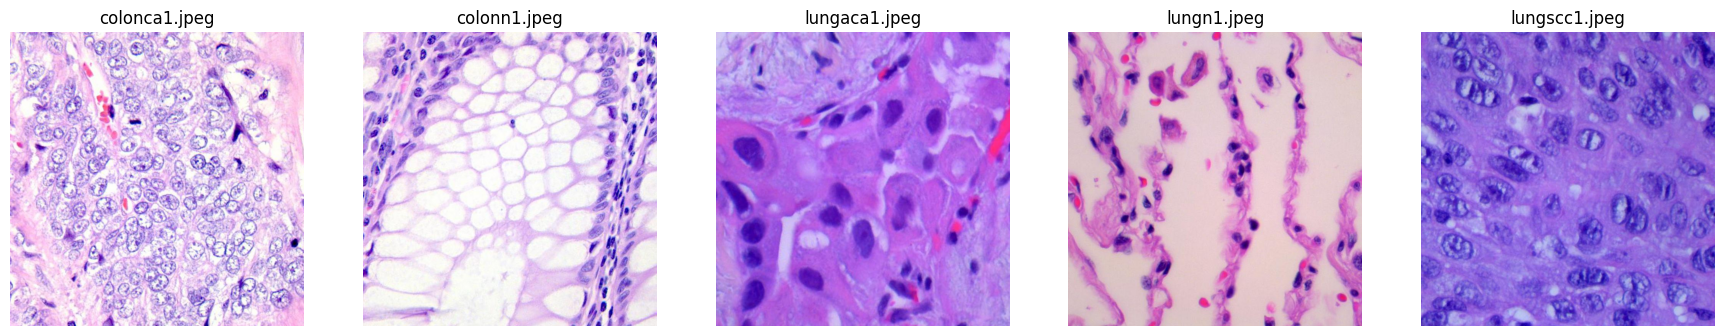

In [3]:
sample_imgs = ['lung_colon_image_set/colon_aca/colonca1.jpeg', 'lung_colon_image_set/colon_n/colonn1.jpeg',
               'lung_colon_image_set/lung_aca/lungaca1.jpeg', 'lung_colon_image_set/lung_n/lungn1.jpeg',
               'lung_colon_image_set/lung_scc/lungscc1.jpeg']


plt.figure(figsize=(22, 8)) 
n = 1

for i in sample_imgs:
    plt.subplot(1, 5, n)
    n += 1
    plt.title(i.split('/')[2])
    plt.imshow(image.load_img(i))
    plt.axis('off')
plt.show()

### Preprocessing the Data

In [4]:
img_path = 'lung_colon_image_set/colon_aca/colonca1.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
#img_array = preprocess_input(img_array)

### Splitting into Train-Test-Validation Sets

In [5]:
train_data = image_dataset_from_directory(data_dir,
                                          validation_split=0.3,
                                          subset="training",
                                          seed=21,
                                          image_size=(224, 224),
                                          batch_size=32)

Found 25000 files belonging to 5 classes.
Using 17500 files for training.


2023-09-19 22:46:45.310435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-19 22:46:45.344481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-19 22:46:45.344848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
test_val_data = image_dataset_from_directory(data_dir,
                                             validation_split=0.3,
                                             subset="validation",
                                             seed=21,
                                             image_size=(224, 224),
                                             batch_size=32)

Found 25000 files belonging to 5 classes.
Using 7500 files for validation.


In [7]:
test_data = test_val_data.take(math.ceil(len(test_val_data) * 0.5))
val_data = test_val_data.take(math.floor(len(test_val_data) * 0.5))

In [8]:
class_names = train_data.class_names
print(class_names)

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


In [9]:
for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


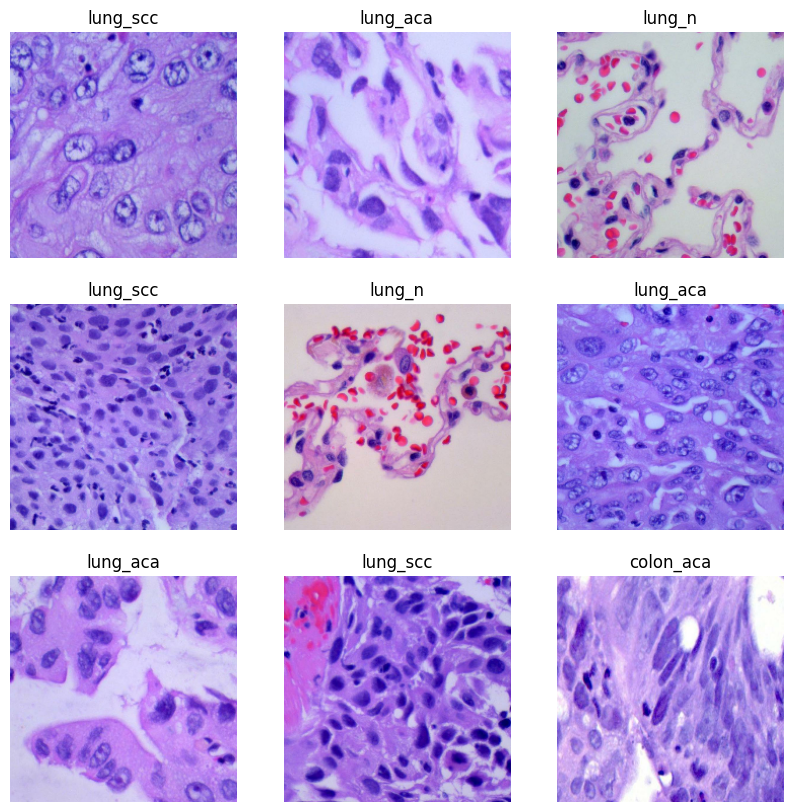

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Normalizing the Data

In [11]:
normalization_layer = keras.layers.Rescaling(1./255)

#normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
normalized_train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
normalized_val_data = val_data.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normalized_train_data))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


### Configuring the Dataset for Performance

In [12]:
#AUTOTUNE = tf.data.AUTOTUNE

#train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
#test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)
#val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

### Building the Model

In [13]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the weights of the pre-trained layers to ensure that they are not updated during training
for layer in base_model.layers:
    layer.trainable = False

# Adding output layer
x = Flatten()(base_model.output)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Training the Model

In [15]:
model.fit(normalized_train_data,
          validation_data=normalized_val_data,
          epochs=10)

Epoch 1/10


ValueError: in user code:

    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses.py", line 2122, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/backend.py", line 5560, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 5) are incompatible
